In [22]:
import numpy as np
import matplotlib.pyplot as plt
import numerical_solvers as num_sol

def minf(V, bm, cm):
    return 0.5 * (1 + np.tanh((V - bm) / cm))

def winf(V, bw, cw):
    return 0.5 * (1 + np.tanh((V - bw) / cw))

def tauw(V, bw, cw):
    return 1 / np.cosh((V - bw) / (2 * cw))

def hodgkinHuxley(t, x, p):
    # Unpack parameters
    C, gfast, gslow, gleak, ENa, EK, Eleak, bm, cm, bw, cw, phiw, Istim = p
    
    # State variables
    V= x[0]
    w = x[1]
    
    # Compute derivatives
    dVdt = (Istim - gfast * minf(V, bm, cm) * (V - ENa) - gslow * w * (V - EK) - gleak * (V - Eleak)) / C
    dwdt = phiw * (winf(V, bw, cw) - w) / tauw(V, bw, cw)
    
    return np.array([dVdt, dwdt])


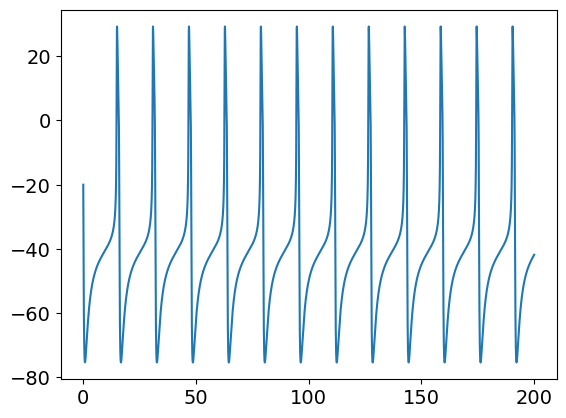

In [23]:
p = np.array([
    2,      # C
    20,     # gfast
    20,     # gslow
    2,      # gleak
    50,     # ENa
    -100,   # EK
    -70,    # Eleak
    -1.2,   # bm
    18,     # cm
    -8,     # bw
    10,     # cw
    0.15,   # phiw
    40      # Istim
])

# Initial conditions
x0 = np.array([-20,0.29])
t0,tfin=0,200
delta_max=1e-2
t,x=num_sol.solve_to(hodgkinHuxley,p,t0,x0,tfin,delta_max,solver='rk4')
plt.plot(t,x[0,:])
plt.show()

Coordinates of a starting point on the limit cycle:  [-75.35773328   0.1042458 ]
Oscillation period of the limit cycle:  15.95
True
Solver converged to limit cycle


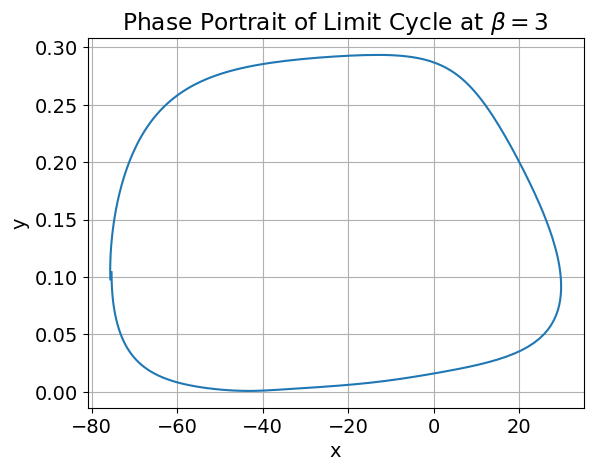

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [24]:
# setting the max timestep size
delta_max=1e-2
# setting the initial guess for the limit cycle (inital guess from inspection of the above graph)
in_guess=np.array([-20,0.29,16])
# setting an appropriate phase condition
def phase_condition(t,x,p):
    return hodgkinHuxley(t,x,p)[0]
# calling lim_cyc_solve and returning the solution as a class
sol=num_sol.lim_cyc_solve(hodgkinHuxley,p,t0,in_guess,delta_max,phase_condition,solver='rk4')
# returning the coordinates and period
print('Coordinates of a starting point on the limit cycle: ', sol.x0[:2])
print('Oscillation period of the limit cycle: ', round(sol.x0[-1],2))
# checking it converged to a limit cycle
print(sol.solver_int)
print(sol.solver_message)
# plotting the limit cycle the solver found
plt.plot(sol.x_vals[0,:],sol.x_vals[1,:])
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'$\text{Phase Portrait of Limit Cycle at } \beta =3$')
plt.grid(True)
plt.show()
plt.figure()

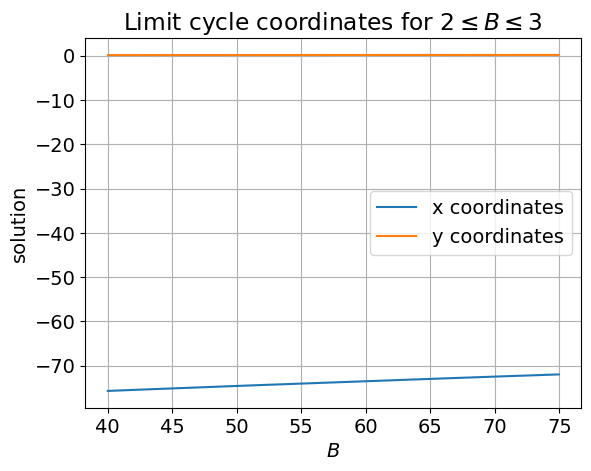

In [25]:
# resetting the parameter arrays
# setting an initial guess (taken from the solved limit cycle in part b)
x0=np.array([-75.35773328, 0.1042458 ,16])
# setting the index of the parameter we want to vary
p_vary=-1
# setting the stepsize and max steps for the paramter values (such that the final p_val is B=3)
stepsize,max_steps=0.05,700
# setting the max timestep size
delta_max=1e-2
# setting solver for shooting
solver='euler'
# setting the arguments required for the limit cycle function
args=(t0,delta_max,solver,phase_condition)
# calling the continuation funciton, noting the args=None as the'shooting' discretisation handles this
IstimVal,u=num_sol.num_cont(hodgkinHuxley,p,x0,p_vary,stepsize,max_steps,method='nat',args=args,solve_for='lim_cyc')
plt.plot(IstimVal,u[0,:],IstimVal,u[1,:])
plt.legend(['x coordinates','y coordinates'])
plt.xlabel(r'$B$')
plt.ylabel('solution')
plt.title(r'Limit cycle coordinates for $2\leq B \leq 3$')
plt.grid(True)
plt.show()

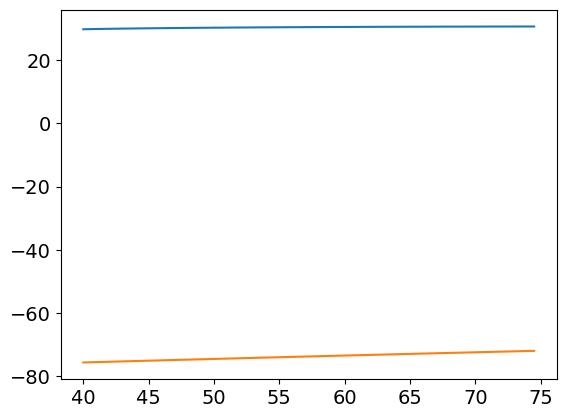

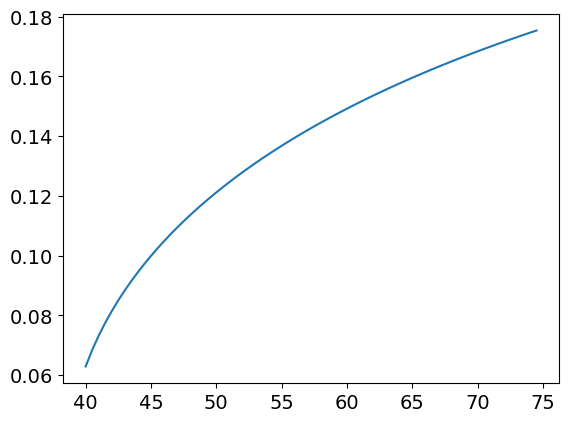

In [26]:
maxV = []
minV = []
Istimvals = []
periods = []
for (idx,V) in enumerate(u[0,:]):
    if idx%10==0:
        w = u[1,idx]
        period = u[2,idx]
        Istim = IstimVal[idx]
        p = np.array([
        2,      # C
        20,     # gfast
        20,     # gslow
        2,      # gleak
        50,     # ENa
        -100,   # EK
        -70,    # Eleak
        -1.2,   # bm
        18,     # cm
        -8,     # bw
        10,     # cw
        0.15,   # phiw
        Istim      # Istim
        ])

        in_guess=np.array([V,w,period])
        sol=num_sol.lim_cyc_solve(hodgkinHuxley,p,t0,in_guess,delta_max,phase_condition,solver='rk4')

        # print('Coordinates of a starting point on the limit cycle: ', sol.x0[:2])
        # print('Oscillation period of the limit cycle: ', round(sol.x0[-1],2))
        # # checking it converged to a limit cycle
        # print(sol.solver_int)
        # print(sol.solver_message)
        # # plotting the limit cycle the solver found
        # plt.plot(sol.x_vals[0,:],sol.x_vals[1,:])
        # plt.xlabel('x')
        # plt.ylabel('y')
        # plt.title(r'$\text{Phase Portrait of Limit Cycle at } \beta =3$')
        # plt.grid(True)
        # plt.show()
        maxV.append(max(sol.x_vals[0,:]))
        minV.append(min(sol.x_vals[0,:]))
        Istimvals.append(Istim)
        periods.append(period)
plt.figure()
plt.plot(Istimvals,maxV,Istimvals,minV)
plt.figure()
plt.plot(Istimvals,1/np.array(periods))
plt.show()




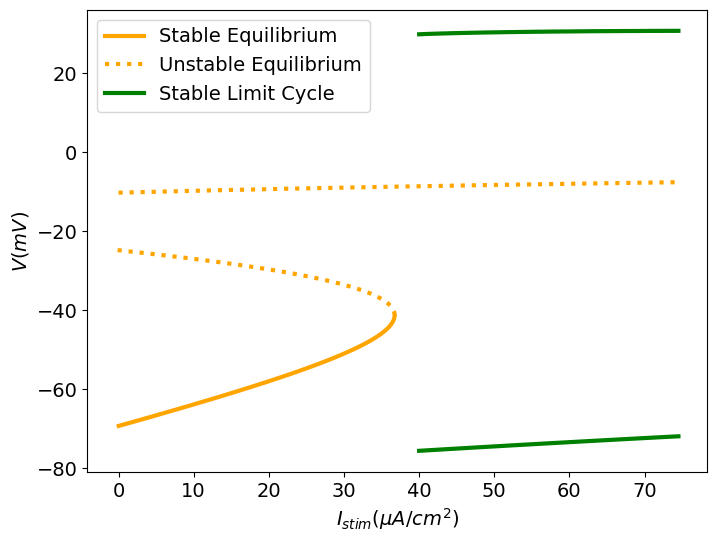

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
file_path = r"C:\Users\sebst\OneDrive\Documents\Uni\Year 4\Public Health Modelling\noLimBif.dat"

df = pd.read_csv(file_path, delimiter="\s+", header=None)
df = df.iloc[1:,:]
bifurcation_param = df.iloc[:, 0]  # First column: control parameter
variable = df.iloc[:, 1]  # Second column: bifurcating variable
stability_col = df.iloc[:, 3]  # Fourth column: stability indicator (1 = stable, 2 = unstable)

# Split data based on stability
df_stable_fold = df[(df.iloc[:, 3] == 1)& (df.iloc[:,1]<-20)]  # Stable (solid line)
df_unstable_fold = df[(df.iloc[:, 3] == 2 )& (df.iloc[:,1]<-20)]
df_unstable_normal = df[(df.iloc[:, 3] == 2) &( df.iloc[:,1]>-20) & (df.iloc[:,0]<75)]  # Unstable (dotted line)

plt.rcParams.update({'font.size': 14,'lines.linewidth': 3}) 
# Create plot
plt.figure(figsize=(8, 6))

# Plot stable branches (solid line)
plt.plot(df_stable_fold.iloc[:, 0], df_stable_fold.iloc[:, 1], 'orange', label="Stable Equilibrium")  # 'k-' = black solid line

# Plot unstable branches (dotted line)
plt.plot(df_unstable_fold.iloc[:, 0], df_unstable_fold.iloc[:, 1], 'orange',linestyle=':', label="Unstable Equilibrium")  # 'k:' = black dotted line

plt.plot(df_unstable_normal.iloc[:, 0], df_unstable_normal.iloc[:, 1], 'orange',linestyle=':')  # 'k:' = black dotted line
plt.plot(Istimvals,minV,"g-")
plt.plot(Istimvals, maxV,"g-",label="Stable Limit Cycle")

# Formatting
plt.xlabel(r"$I_{stim} (\mu A/cm^2)$")
plt.ylabel(r"$V (mV)$")
plt.legend()
plt.show()